# Include vs Excluse sequence order in Simillarity Measure

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


## read in data

In [2]:
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v02.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_mn_20200918.csv") #For calculating centroids
# enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_union.csv")
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"

In [3]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(cd_block_col)} for ward,df in cd_1850.groupby(cd_ward_col)}

In [4]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= [ward_col, "CENSUS_PAGENUM"], 
                                  right_on = [ward_col, "CENSUS_PAGENO_HOUSEHOLD"])

## 1. No sequence order

In [76]:
### without enum_dist_order
all_cols = ['CENSUS_SERIAL', 'CENSUS_AGE', 'CENSUS_PAGENUM', 'CENSUS_GENDER', 'CENSUS_RACE',
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", 'CENSUS_FIRST_NAME', 'CENSUS_LAST_NAME', 'CENSUS_OCCUPATION', 'CENSUS_IMPREL',
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, 
                             dwelling_col=dwelling_col, block_col =  block_col, 
                             x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(d=0.1, enumerator_dist = True, 
                                 dwelling = True, fixed = True, distance = True)
n_cluster_list = [10,20,30,40,50]
result_train_n_mode = {}
result_test_n_mode = {}
model_n_pro = {}

for k in n_cluster_list:
   
    kpro_model = KModes(n_clusters=k, init = "random", n_init = 1)

    cate_similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
    cont_similar_cols = []
    try: 
        census_enum_seq.apply_similarity(kpro_model=kpro_model, cate_sim_columns=cate_similar_cols, 
                                         cont_sim_columns=cont_similar_cols)
    except:
        print(f'failed at n={k}')
        result_train_n_mode[k] = np.nan
        result_test_n_mode[k] = np.nan
        break
    
    transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
    # define pipeline
    pipeline = Pipeline(steps=[('preprocess', transformer), 
                               ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 5, 
                                                           n_estimators = 30))])
    interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                                 KMeans(5), block_centroids)
    score, model = interpolate_sequences.kmeans_best(5)
    interpolate_sequences.set_clustering_algo(model)
    interpolate_sequences.apply_clustering(algo_fit = True)
    # interpolate_sequences.clustervis(kmeans = True)

    interpolate_sequences.cross_validate_model(k=10)
#     print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
#     print('Test score:', interpolate_sequences.test_score)
#     print("avg Test score:", np.array(interpolate_sequences.test_score).mean())
    result_train_n_mode[k] = np.array(interpolate_sequences.train_score).mean()
    result_test_n_mode[k] = np.array(interpolate_sequences.test_score).mean() 
    

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration


d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
n is 5 and it's the 10th iteration


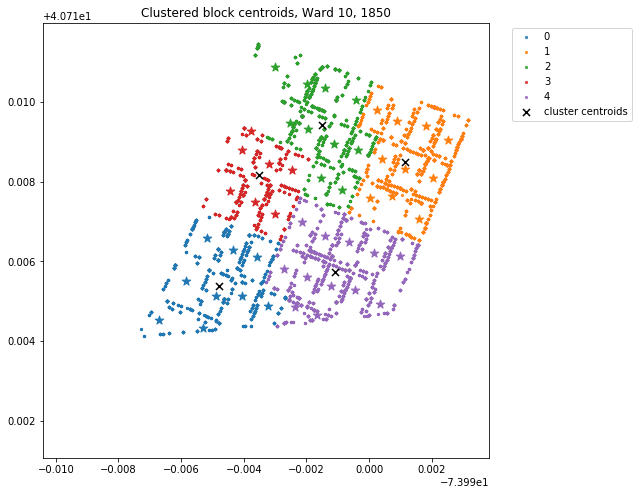

In [96]:
### without enum_dist_order
all_cols = ['CENSUS_SERIAL', 'CENSUS_AGE', 'CENSUS_PAGENUM', 'CENSUS_GENDER', 'CENSUS_RACE',
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", 'CENSUS_FIRST_NAME', 'CENSUS_LAST_NAME', 'CENSUS_OCCUPATION', 'CENSUS_IMPREL',
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, 
                             dwelling_col=dwelling_col, block_col =  block_col, 
                             x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(d=0.1, enumerator_dist = True, 
                                 dwelling = True, fixed = True, distance = True)
n_cluster_list = [10]#,20,30,40,50]
result_train_n_mode = {}
result_test_n_mode = {}
model_n_pro = {}

for k in n_cluster_list:
   
    kpro_model = KModes(n_clusters=k, init = "random", n_init = 1)

    cate_similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
    cont_similar_cols = []
    try: 
        census_enum_seq.apply_similarity(kpro_model=kpro_model, cate_sim_columns=cate_similar_cols, 
                                         cont_sim_columns=cont_similar_cols)
    except:
        print(f'failed at n={k}')
        result_train_n_mode[k] = np.nan
        result_test_n_mode[k] = np.nan
        break
    
    transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
    # define pipeline
    pipeline = Pipeline(steps=[('preprocess', transformer), 
                               ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 5, 
                                                           n_estimators = 30))])
    interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                                 KMeans(5), block_centroids)
    score, model = interpolate_sequences.kmeans_best(5)
    interpolate_sequences.set_clustering_algo(model)
    interpolate_sequences.apply_clustering(algo_fit = True)
    interpolate_sequences.clustervis(kmeans = True)

    interpolate_sequences.cross_validate_model(k=10)
#     print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
#     print('Test score:', interpolate_sequences.test_score)
#     print("avg Test score:", np.array(interpolate_sequences.test_score).mean())
    result_train_n_mode[k] = np.array(interpolate_sequences.train_score).mean()
    result_test_n_mode[k] = np.array(interpolate_sequences.test_score).mean() 
    

Text(0.5, 0, 'n_cluster')

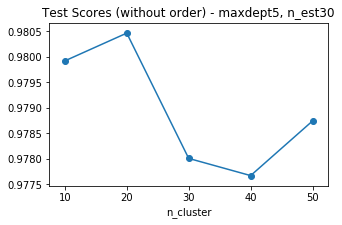

In [78]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(list(result_train_n_mode.keys()), list(result_train_n_mode.values()))
ax.scatter(list(result_train_n_mode.keys()), list(result_train_n_mode.values()))  
ax.set_title('Train Scores (without order) - maxdept5, n_est30')
ax.set_xlabel('n_cluster')

Text(0.5, 0, 'n_cluster')

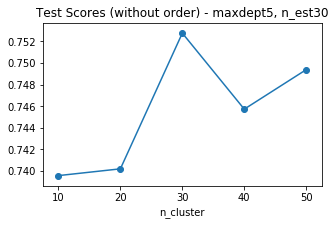

In [77]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(list(result_test_n_mode.keys()), list(result_test_n_mode.values()))
ax.scatter(list(result_test_n_mode.keys()), list(result_test_n_mode.values()))  
ax.set_title('Test Scores (without order) - maxdept5, n_est30')
ax.set_xlabel('n_cluster')

In [95]:
# import pickle

# a = (result_train_n_mode, result_test_n_mode)

# with open('../../result_no_sequence_order.pickle', 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [97]:
# with open('../../result_no_sequence_order.pickle', 'rb') as handle:
#     (result_train_n_mode, result_test_n_mode) = pickle.load(handle)

## 2. With sequence order

In [79]:
### with sequence order in similarity check 

census_enum_seq_order = CensusData(ward10_enumerators, ward_col=ward_col, 
                             dwelling_col=dwelling_col, block_col =  block_col, 
                             x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq_order.apply_sequencing(d=0.1, enumerator_dist = True, 
                                 dwelling = True, fixed = True, distance = True)

gamma_list = [0.1, 1, 5, 10, 20, 25, 40, 50]
n_cluster_list = [10] #,20] #,30,40,50]  ### the other half is done in a different file
result_train_n_pro = {}
result_test_n_pro = {}

for k in n_cluster_list:
    
    
    result_train_g = {}
    result_test_g = {}  
    model_g = {}
    ## runn= gamma
    for g in gamma_list:
        
        kpro_model = KPrototypes(n_clusters=k, init = "random", n_init = 1, gamma=g)
        cate_similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
        cont_similar_cols = ['sequence_order_enum']
        try:
            census_enum_seq_order.apply_similarity(kpro_model=kpro_model, cate_sim_columns=cate_similar_cols, 
                                             cont_sim_columns=cont_similar_cols)
        except:
            print(f'failed at n={k} and g={g}')
            result_train_g[g] = np.nan
            result_test_g[g] = np.nan
            break
            
        all_cols = ['CENSUS_SERIAL', 'CENSUS_AGE', 'CENSUS_PAGENUM', 'CENSUS_GENDER', 'CENSUS_RACE',
                    "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                    "CENSUS_MARST", 'CENSUS_FIRST_NAME', 'CENSUS_LAST_NAME', 'CENSUS_OCCUPATION', 'CENSUS_IMPREL',
                    "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
                    "enum_dist_order"]

        transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                                      ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
        # define pipeline
        pipeline = Pipeline(steps=[('preprocess', transformer), 
                                   ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 5, 
                                                               n_estimators = 30))])
        interpolate_sequences_order = CentroidInterpolator(census_enum_seq_order, 10, pipeline, all_cols + ['similarity_label'],
                                                     KMeans(5), block_centroids)
        score, model = interpolate_sequences_order.kmeans_best(5)
        interpolate_sequences_order.set_clustering_algo(model)
        interpolate_sequences_order.apply_clustering(algo_fit = True)
        # interpolate_sequences.clustervis(kmeans = True)

        interpolate_sequences_order.cross_validate_model(k=5)
    #     print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
    #     print('Test score:', interpolate_sequences.test_score)
    #     print("avg Test score:", np.array(interpolate_sequences.test_score).mean())
        result_train_g[g] = np.array(interpolate_sequences_order.train_score).mean()
        result_test_g[g] = np.array(interpolate_sequences_order.test_score).mean()  
    
    result_train_n_pro[k] = result_train_g
    result_test_n_pro[k] = result_test_g

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration
n is 5 and it's the 10th iteration


In [80]:
import pickle

a = (result_train_n_pro, result_test_n_pro)

with open('../../result_1.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
with open('../../result_2.pickle', 'rb') as handle:
    (result_train_n_pro_2, result_test_n_pro_2) = pickle.load(handle)
    
with open('../../result_3.pickle', 'rb') as handle:
    (result_train_n_pro_3, result_test_n_pro_3) = pickle.load(handle)

In [82]:
result_train_n_pro_merged = {**result_train_n_pro, **result_train_n_pro_2}.copy()
result_train_n_pro_merged = {**result_train_n_pro_merged, **result_train_n_pro_3}.copy()

result_test_n_pro_merged = {**result_test_n_pro, **result_test_n_pro_2}.copy()
result_test_n_pro_merged = {**result_test_n_pro_merged, **result_test_n_pro_3}.copy()

result_train_n_pro_df = pd.DataFrame(result_train_n_pro_merged).T
result_test_n_pro_df = pd.DataFrame(result_test_n_pro_merged).T

### Result

* No obvious pattern of what combination of gamma and n_cluster performing the best
* Similarity labels do not converge in some configurations, resulting in NaN

In [87]:
result_test_n_pro_df.sort_index(inplace=True)
result_test_n_pro_df

,0.1,1.0,5.0,10.0,20.0,25.0,40.0,50.0
10,0.744235,0.750151,0.717296,0.738279,0.759053,0.719319,0.728944,0.733866
20,0.743395,0.725932,0.737996,0.738359,0.730675,0.722607,0.735795,0.727990
30,0.746221,0.739160,0.748838,NaN,NaN,NaN,NaN,NaN
40,0.728425,0.724157,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'n_cluster')

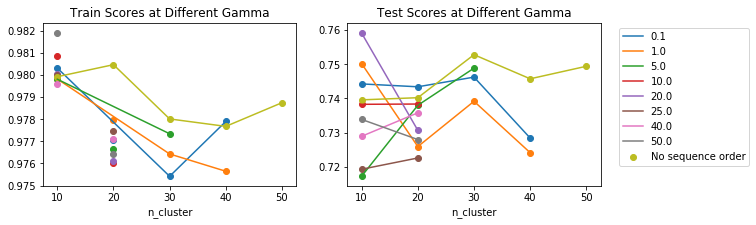

In [94]:
fig, ax = plt.subplots(1,2,figsize=(10,3))

for g in result_test_n_pro_df.columns:
    ax[0].plot(result_train_n_pro_df[g], label=str(g))
    ax[0].scatter(result_train_n_pro_df[g].index, result_train_n_pro_df[g].values)  
ax[0].plot(list(result_train_n_mode.keys()), list(result_train_n_mode.values()))
ax[0].scatter(list(result_train_n_mode.keys()), list(result_train_n_mode.values()), label=str('No sequence order'))  

ax[0].set_title('Train Scores at Different Gamma')
ax[0].set_xlabel('n_cluster')

for g in result_test_n_pro_df.columns:
    ax[1].plot(result_test_n_pro_df[g], label=str(g))
    ax[1].scatter(result_test_n_pro_df[g].index, result_test_n_pro_df[g].values)  
ax[1].plot(list(result_test_n_mode.keys()), list(result_test_n_mode.values()))
ax[1].scatter(list(result_test_n_mode.keys()), list(result_test_n_mode.values()), label=str('No sequence order'))  

ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].set_title('Test Scores at Different Gamma')
ax[1].set_xlabel('n_cluster')